Import useful libraries

In [7]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from tqdm import tqdm
from evaluation import Evaluation
from main import SearchEngine
import numpy as np
import matplotlib.pyplot as plt
# import stats
from scipy import stats
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from informationRetrieval import InformationRetrieval

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mnop1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


Evaaluation function

In [2]:
def evaluate(doc_IDs_ordered, query_ids, qrels):
    eva = Evaluation()
    precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []
    for k in range(1, 11):
        precision = eva.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
        precisions.append(precision)

        recall = eva.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
        recalls.append(recall)
        
        fscore = eva.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
        fscores.append(fscore)
        
        print("Precision, Recall and F-score @ " +  str(k) + " : " + str(precision) + ", " + str(recall) +  ", " + str(fscore))
       
        MAP = eva.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
        MAPs.append(MAP)
        
        nDCG = eva.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
        nDCGs.append(nDCG)
        
        print("MAP, nDCG @ " +  str(k) + " : " + str(MAP) + ", " + str(nDCG))

    # Plot the metrics and save plot 
    # plt.plot(range(1, 11), precisions, label="Precision")
    # plt.plot(range(1, 11), recalls, label="Recall")
    # plt.plot(range(1, 11), fscores, label="F-Score")
    # plt.plot(range(1, 11), MAPs, label="MAP")
    # plt.plot(range(1, 11), nDCGs, label="nDCG")
    # plt.legend()
    # plt.title("Evaluation Metrics - Cranfield Dataset")
    # plt.xlabel("k")

    return

POS tagging function

In [3]:
def pos_tagging(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_tagged_text = " ".join([f"{word}_{tag}" for word, tag in pos_tags])
    return pos_tagged_text

Testing function

In [4]:
def testing(qrels, doc_IDs_ordered, k):
    # calculate query precision, recall, Fscore, nDCG for each query and store in array
    eval_test = Evaluation()
    q_prec = []
    q_recall = []
    q_fscore = []
    q_nDCG = []
    df = pd.DataFrame(qrels)
    for i in range(len(doc_IDs_ordered)):
        query_doc_IDs_ordered = doc_IDs_ordered[i]
        true_doc_IDs = list(map(int, df[df['query_num'] == str(i+1)]['id'].tolist()))
        
        precision = eval_test.queryPrecision(query_doc_IDs_ordered, i+1, true_doc_IDs, k)
        q_prec.append(precision)
        recall = eval_test.queryRecall(query_doc_IDs_ordered, i+1, true_doc_IDs, k)
        q_recall.append(recall)
        fscore = eval_test.queryFscore(query_doc_IDs_ordered, i+1, true_doc_IDs, k)
        q_fscore.append(fscore)
        
    for j in range(len(doc_IDs_ordered)):
        query_doc_IDs_ordered = doc_IDs_ordered[j]
        true_doc_IDs_nDCG = list(map(int, df[df['query_num'] == str(j+1)]['id'].tolist()))
        print(true_doc_IDs_nDCG)
        print(query_doc_IDs_ordered)
        nDCG = eval_test.queryNDCG(query_doc_IDs_ordered, j+1, true_doc_IDs_nDCG, k)
        print(nDCG)
        q_nDCG.append(nDCG)

    return q_prec, q_recall, q_fscore, q_nDCG

Hypothesis Testing function

In [5]:
# hypothesis testing function a vs b
def hypothesis_test(a, b):
    n = len(a)
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    var_a = np.var(a)
    var_b = np.var(b)
    t = (mean_a - mean_b) / np.sqrt(var_a/n + var_b/n)

    # also p value
    p = 1 - stats.t.cdf(t, n-1)
    return t, p


Loading and preprocessing Dataset

In [8]:
# Read queries
queries_json = json.load(open("./cranfield/cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]
# Preprocess queries 
preprocessed_queries = json.load(open("./output/stopword_removed_queries.txt", 'r'))[:]

# Read documents
docs_json = json.load(open("./cranfield/cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]
# Preprocess documents
preprocessed_docs = json.load(open("./output/stopword_removed_docs.txt", 'r'))[:]

# pos tagging
pos_tagged_docs = [pos_tagging(doc) for doc in docs]
pos_tagged_queries = [pos_tagging(query) for query in queries]

# open qrels
qrels = json.load(open("./cranfield/cran_qrels.json", 'r'))[:]

In [9]:
print(docs)

['experimental investigation of the aerodynamics of a wing in a slipstream .   an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem .   the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary-layer-control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory .   an empirical evaluation of the destalling effects was made for the specific configuration of the experiment .', "simple shear flow past a flat plate in an incompressible fluid of small viscosity . 

Basic Vector Space Model

In [10]:
# for basic vector space model
IR = InformationRetrieval()
IR.buildIndex(preprocessed_docs, doc_ids)
doc_ids_ordered_vsm = IR.rank(preprocessed_queries)

# cosine_sim_vsm = np.dot(tfidf_docs.T, tfidf_queries)
# doc_ids_ordered_vsm = (np.argsort(cosine_sim_vsm, axis=0)+1)[::-1].T.tolist()

Latent Semantic Analysis

In [11]:
# latent semantic analysis
corpus = docs + queries
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()
cols = ['doc_' + str(i) for i in range(1, X.shape[0] + 1)]

tfidf_df = pd.DataFrame(X.T.toarray(), index=feature_names, columns=cols)
tfidf_docs = tfidf_df[tfidf_df.columns[:len(docs)]]
tfidf_queries = tfidf_df[tfidf_df.columns[len(docs):]]
tfidf_df.head()

doc_1  doc_2  doc_3  doc_4  doc_5  doc_6  doc_7  doc_8  doc_9  \
00           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
000          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0001         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0005         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
000degree    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

           doc_10  ...  doc_1616  doc_1617  doc_1618  doc_1619  doc_1620  \
00            0.0  ...       0.0       0.0       0.0       0.0       0.0   
000           0.0  ...       0.0       0.0       0.0       0.0       0.0   
0001          0.0  ...       0.0       0.0       0.0       0.0       0.0   
0005          0.0  ...       0.0       0.0       0.0       0.0       0.0   
000degree     0.0  ...       0.0       0.0       0.0       0.0       0.0   

           doc_1621  doc_1622  doc_1623  doc_1624  doc_1625  
00              0.0       0.0       0.0       0.0       0.0  
000             0.0       0.0       0.0       0.0       0.0  
0001            0.0       0.0       0.0       0.0       0.0  
0005            0.0       0.0       0.0       0.0       0.0  
000degree       0.0       0.0       0.0       0.0       0.0  

[5 rows x 1625 columns]

Precision, Recall and F-score @ 1 : 0.52, 0.07963891626576938, 0.13298029556412594
MAP, nDCG @ 1 : 0.52, 0.39111111111111113
Precision, Recall and F-score @ 2 : 0.4577777777777778, 0.14019525992211299, 0.2034059052488122
MAP, nDCG @ 2 : 0.58, 0.3825015166813581
Precision, Recall and F-score @ 3 : 0.40740740740740733, 0.18372223199554621, 0.2376207427699161
MAP, nDCG @ 3 : 0.5914814814814814, 0.368527068269295
Precision, Recall and F-score @ 4 : 0.37777777777777777, 0.22051581192124242, 0.26029458429733715
MAP, nDCG @ 4 : 0.5871604938271606, 0.3628114461592271
Precision, Recall and F-score @ 5 : 0.3448888888888891, 0.25032238370820625, 0.27049297515557646
MAP, nDCG @ 5 : 0.5782283950617284, 0.36269197405488246
Precision, Recall and F-score @ 6 : 0.32148148148148153, 0.2782899558371819, 0.27759257285681155
MAP, nDCG @ 6 : 0.5734728395061729, 0.36447389733884433
Precision, Recall and F-score @ 7 : 0.3028571428571432, 0.30303296110237493, 0.281306650242008
MAP, nDCG @ 7 : 0.566607054673721

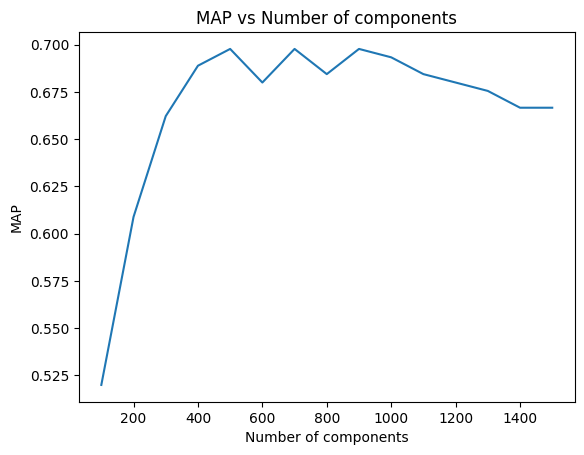

In [12]:
components = [100*i for i in range(1, 16)]

eval = Evaluation()
eval_results = []
MAP = []
for component in components:
    svd = TruncatedSVD(n_components=component)
    svd.fit(tfidf_docs.T)
    svd_docs = svd.transform(tfidf_docs.T).T
    svd_queries = svd.transform(tfidf_queries.T).T

    # Calculate cosine similarity
    cosine_sim = np.matmul(svd_docs.T, svd_queries)
    ordered_docs = (np.argsort(cosine_sim, axis=0)+1)[::-1].T.tolist()

    evaluate(ordered_docs, query_ids, qrels)

    MAP.append(eval.meanAveragePrecision(ordered_docs, query_ids, qrels, k=1))


# plot MAP vs components
plt.plot(components, MAP)
plt.xlabel('Number of components')
plt.ylabel('MAP')
plt.title('MAP vs Number of components')
plt.show()

In [13]:
# do again for best number of components
best_component = components[np.argmax(MAP)]
svd = TruncatedSVD(n_components=best_component)
svd.fit(tfidf_docs.T)
svd_docs = svd.transform(tfidf_docs.T).T
svd_queries = svd.transform(tfidf_queries.T).T

# Calculate cosine similarity
cosine_sim = np.matmul(svd_docs.T, svd_queries)
ordered_docs_lsa = (np.argsort(cosine_sim, axis=0)+1)[::-1].T.tolist()

evaluate(ordered_docs_lsa, query_ids, qrels)

Precision, Recall and F-score @ 1 : 0.6888888888888889, 0.1149074890147342, 0.1895172197873247
MAP, nDCG @ 1 : 0.6888888888888889, 0.5577777777777778
Precision, Recall and F-score @ 2 : 0.5711111111111111, 0.18587734205003703, 0.26415332971159533
MAP, nDCG @ 2 : 0.7377777777777778, 0.5156321410989645
Precision, Recall and F-score @ 3 : 0.5125925925925927, 0.24612430582385406, 0.30975193324926925
MAP, nDCG @ 3 : 0.7355555555555555, 0.49281257236919246
Precision, Recall and F-score @ 4 : 0.4622222222222222, 0.28878016363143594, 0.3288263079376692
MAP, nDCG @ 4 : 0.7225925925925927, 0.4806026667051708
Precision, Recall and F-score @ 5 : 0.4106666666666671, 0.31221167067607064, 0.32738767252898354
MAP, nDCG @ 5 : 0.7174012345679012, 0.4694808406961785
Precision, Recall and F-score @ 6 : 0.38370370370370377, 0.34460622057062046, 0.33510371364122093
MAP, nDCG @ 6 : 0.6991333333333334, 0.47373365970488984
Precision, Recall and F-score @ 7 : 0.3593650793650798, 0.3717422160203416, 0.3372976989

In [14]:
print(best_component)

500


In [15]:
q_prec_vsm, q_recall_vsm, q_fscore_vsm, q_nDCG_vsm = testing(qrels, doc_ids_ordered_vsm, 7)
q_prec_lsa, q_recall_lsa, q_fscore_lsa, q_nDCG_lsa = testing(qrels, ordered_docs_lsa, 7)

[184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880, 486]
[51, 359, 746, 12, 56, 944, 879, 878, 573, 486, 1186, 13, 253, 817, 1361, 874, 14, 663, 584, 665, 875, 141, 818, 332, 435, 792, 414, 184, 1169, 102, 172, 1144, 747, 781, 1149, 1328, 100, 78, 491, 378, 758, 876, 429, 884, 925, 1194, 104, 25, 685, 329, 316, 29, 395, 800, 219, 305, 526, 540, 202, 606, 1163, 1191, 1034, 284, 252, 1003, 592, 1155, 1121, 240, 415, 982, 5, 1168, 1048, 585, 1042, 158, 374, 251, 686, 193, 707, 729, 563, 811, 114, 261, 497, 294, 1184, 728, 1201, 280, 546, 1165, 1331, 1158, 1128, 300, 726, 640, 1212, 431, 220, 629, 456, 687, 180, 327, 681, 719, 390, 1268, 657, 542, 1332, 1147, 1372, 1050, 1263, 1167, 120, 700, 1334, 309, 315, 214, 883, 1305, 509, 522, 142, 62, 306, 601, 1198, 860, 1197, 57, 1335, 1164, 1261, 358, 328, 1380, 1026, 1207, 1181, 216, 195, 52, 756, 593, 349, 917, 370, 235, 453, 951, 666, 69, 630, 554, 541, 472, 634, 799, 

In [16]:
print(q_nDCG_lsa, q_nDCG_vsm)

[0.6092220927569983, 0.5566806603542075, 0.9204246927275325, 0.4569494273838043, 0.3371300007179386, 0.5700562581660739, 0.6175243037661478, 0.5658526860945212, 0.7360877997121478, 0.6017009905381645, 0.6396447038743495, 0.5514205154533555, 0.487191810963602, 0.6308163166922905, 0.6645649565734895, 0.7212068471037865, 0.38088543088308763, 0.4136344813315292, 0.09860310494062113, 0.7584697788638017, 0.6778801605892193, 0.0, 0.7250191171562099, 0.870450085168843, 0.42536671877859594, 0.11862167037485505, 0.17195110284692253, 0.0, 0.40456527711355206, 0.467688320920908, 0.5449702648457346, 0.4882076950812061, 0.97007812979315, 0.6597970871108034, 0.0, 0.0, 0.3612809880336729, 0.2841256033126781, 0.24456903991468132, 0.21782718450339825, 0.745497693692505, 0.706175894730535, 0.6852015320693751, 0.0, 0.613540470072263, 0.6874585189135985, 0.5778387506356741, 0.6320686750437112, 0.9132224589335864, 0.0, 0.5532275767658114, 0.5494052675344797, 0.3861535931507758, 0.5551669929315566, 0.3017386

Hypothesis Testing for VSM vs LSA

In [17]:
# hypothesis testing VSM vs LSA
t_prec, p_prec = hypothesis_test(q_prec_vsm, q_prec_lsa)
t_recall, p_recall = hypothesis_test(q_recall_vsm, q_recall_lsa)
t_fscore, p_fscore = hypothesis_test(q_fscore_vsm, q_fscore_lsa)
t_nDCG, p_nDCG = hypothesis_test(q_nDCG_vsm, q_nDCG_lsa)

print("Precision: t = ", t_prec, ", p = ", p_prec)
print("Recall: t = ", t_recall, ", p = ", p_recall)
print("Fscore: t = ", t_fscore, ", p = ", p_fscore)
print("nDCG: t = ", t_nDCG, ", p = ", p_nDCG)

Precision: t =  -1.1229265608960728 , p =  0.8686645990060168
Recall: t =  -0.8486693931353769 , p =  0.8015143543433514
Fscore: t =  -1.085419007472912 , p =  0.8605485675102066
nDCG: t =  -1.3378995007816976 , p =  0.9088570720992329


POS Tagged LSA

In [18]:
# analysis for pos tagged
corpus_pos = pos_tagged_docs + pos_tagged_queries

vectorizer = TfidfVectorizer()
X_pos = vectorizer.fit_transform(corpus_pos)

feature_names_pos = vectorizer.get_feature_names_out()
cols_pos = ['doc_' + str(i) for i in range(1, X_pos.shape[0] + 1)]

tfidf_df_pos = pd.DataFrame(X_pos.T.toarray(), index=feature_names_pos, columns=cols_pos)
tfidf_docs_pos = tfidf_df_pos[tfidf_df_pos.columns[:len(docs)]]
tfidf_queries_pos = tfidf_df_pos[tfidf_df_pos.columns[len(docs):]]
tfidf_df_pos.head()

doc_1  doc_2  doc_3  doc_4  doc_5  doc_6  doc_7  doc_8  doc_9  \
000             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0001_cd         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0005_nn         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
000_cd          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
000degree_cd    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

              doc_10  ...  doc_1616  doc_1617  doc_1618  doc_1619  doc_1620  \
000              0.0  ...       0.0       0.0       0.0       0.0       0.0   
0001_cd          0.0  ...       0.0       0.0       0.0       0.0       0.0   
0005_nn          0.0  ...       0.0       0.0       0.0       0.0       0.0   
000_cd           0.0  ...       0.0       0.0       0.0       0.0       0.0   
000degree_cd     0.0  ...       0.0       0.0       0.0       0.0       0.0   

              doc_1621  doc_1622  doc_1623  doc_1624  doc_1625  
000                0.0       0.0       0.0       0.0       0.0  
0001_cd            0.0       0.0       0.0       0.0       0.0  
0005_nn            0.0       0.0       0.0       0.0       0.0  
000_cd             0.0       0.0       0.0       0.0       0.0  
000degree_cd       0.0       0.0       0.0       0.0       0.0  

[5 rows x 1625 columns]

In [19]:
cosine_sim_lsa_pos = np.dot(tfidf_docs_pos.T, tfidf_queries_pos)
doc_ids_ordered_lsa_pos = (np.argsort(cosine_sim_lsa_pos, axis=0)+1)[::-1].T.tolist()

In [20]:
# for pos tagged LSA

components = [100*i for i in range(1, 16)]

eval = Evaluation()
eval_results = []
MAP = []
for component in components:
    svd = TruncatedSVD(n_components=component)
    svd.fit(tfidf_docs_pos.T)
    svd_docs = svd.transform(tfidf_docs_pos.T).T
    svd_queries = svd.transform(tfidf_queries_pos.T).T

    # Calculate cosine similarity
    cosine_sim = np.matmul(svd_docs.T, svd_queries)
    ordered_docs = (np.argsort(cosine_sim, axis=0)+1)[::-1].T.tolist()

    evaluate(ordered_docs, query_ids, qrels)

    MAP.append(eval.meanAveragePrecision(ordered_docs, query_ids, qrels, k=1))


# plot MAP vs components
plt.plot(components, MAP)
plt.xlabel('Number of components')
plt.ylabel('MAP')
plt.title('MAP vs Number of components')
plt.show()

Precision, Recall and F-score @ 1 : 0.4222222222222222, 0.061073290253682376, 0.10329204554254257
MAP, nDCG @ 1 : 0.4222222222222222, 0.31222222222222223
Precision, Recall and F-score @ 2 : 0.4, 0.11673673819692464, 0.17129726902906497
MAP, nDCG @ 2 : 0.49777777777777776, 0.32309321695164506
Precision, Recall and F-score @ 3 : 0.3614814814814811, 0.1582496401948842, 0.2064531175579152
MAP, nDCG @ 3 : 0.5144444444444445, 0.31581570519194774
Precision, Recall and F-score @ 4 : 0.3388888888888889, 0.19573881731091436, 0.23072637656194678
MAP, nDCG @ 4 : 0.5171604938271606, 0.31952161428391757
Precision, Recall and F-score @ 5 : 0.30133333333333345, 0.2138673303145564, 0.2321271048699234
MAP, nDCG @ 5 : 0.513537037037037, 0.3128372595362696
Precision, Recall and F-score @ 6 : 0.28444444444444433, 0.24114326996562507, 0.24177630772126596
MAP, nDCG @ 6 : 0.5084654320987654, 0.3180279671815305
Precision, Recall and F-score @ 7 : 0.2615873015873018, 0.25676958192527044, 0.24051232426626018
MAP

In [ ]:
# do again for best number of components
best_component = components[np.argmax(MAP)]
svd = TruncatedSVD(n_components=best_component)
svd.fit(tfidf_docs_pos.T)
svd_docs = svd.transform(tfidf_docs_pos.T).T
svd_queries = svd.transform(tfidf_queries_pos.T).T

# Calculate cosine similarity
cosine_sim = np.matmul(svd_docs.T, svd_queries)
ordered_docs_pos_lsa = (np.argsort(cosine_sim, axis=0)+1)[::-1].T.tolist()

evaluate(ordered_docs_pos_lsa, query_ids, qrels)

In [ ]:
# compare normal LSA vs pos tagged LSA
q_prec_lsa_pos, q_recall_lsa_pos, q_fscore_lsa_pos, q_nDCG_lsa_pos = testing(qrels, ordered_docs_pos_lsa, 7)
q_prec_lsa, q_recall_lsa, q_fscore_lsa, q_nDCG_lsa = testing(qrels, ordered_docs_lsa, 7)

Hypothesis testing for LSA vs POS tagged LSA

In [ ]:
# hypothesis testing LSA vs LSA pos
t_prec, p_prec = hypothesis_test(q_prec_lsa, q_prec_lsa_pos)
t_recall, p_recall = hypothesis_test(q_recall_lsa, q_recall_lsa_pos)
t_fscore, p_fscore = hypothesis_test(q_fscore_lsa, q_fscore_lsa_pos)
t_nDCG, p_nDCG = hypothesis_test(q_nDCG_lsa, q_nDCG_lsa_pos)

print("Precision: t = ", t_prec, ", p = ", p_prec)
print("Recall: t = ", t_recall, ", p = ", p_recall)
print("Fscore: t = ", t_fscore, ", p = ", p_fscore)
print("nDCG: t = ", t_nDCG, ", p = ", p_nDCG)
